In [1]:
from backend import *
from tqdm.notebook import tqdm

# Preprocessing Earthquake probabilities

In [205]:
# Creating the DataFrame of the earthquakes' probabilities
df = pd.read_table('../incremental_annual_rates/incremental_annual_rates_USA.txt', sep='\s+', header=None)

df.columns = ['Long', 'Lat'] + [str(np.around(x,1)) for x in np.arange(4.6, 9.6, 0.1)]
df.drop(df.columns[42:], axis=1, inplace=True)
df.fillna(value=0.0, inplace=True)
df = df[df['4.6'] != 0.0]

df.to_csv('incremental_annual_rates/incremental_annual_rates_italy_without_zeros.csv', index=False)

In [201]:
df = pd.read_csv('../incremental_annual_rates/incremental_annual_rates_USA.csv')
df.describe()

,Lat,Long,4.6,4.7,4.8,4.9,5.0,5.1,5.2,5.3,...,7.7,7.8,7.9,8.0,8.1,8.2,8.3,8.4,8.5,8.6
0,-82.0,24.5,5.522443e-09,4.386632e-09,3.484426e-09,2.767778e-09,2.198524e-09,1.746350e-09,1.387175e-09,1.101872e-09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-81.9,24.5,7.100443e-09,5.640082e-09,4.480077e-09,3.558651e-09,2.826737e-09,2.245357e-09,1.783551e-09,1.416725e-09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df = df[df['4.6'] != 0.0]

In [12]:
# Delete If no earthquake exist with such magnitude
df.drop(labels=['8.5', '8.6'], axis=1, inplace=True)

In [14]:
# Convert the rates to probabilities
prob_matrix = df.drop(['Lat', 'Long'], axis=1).to_numpy()
scale = prob_matrix.sum()
print(scale)
df.iloc[:,2:] = df.iloc[:,2:] / scale

df.to_csv('earthquake_probabilities/usa.csv', index=False)

In [18]:
df = pd.read_csv('earthquake_probabilities/usa.csv')

In [ ]:
# Downsample the eartquakes
res = 2
ds = df.copy()
ds['Lat'] = (ds['Lat']*res).astype(int)
ds['Long'] = (ds['Long']*res).astype(int)
ds = ds.groupby(['Lat','Long']).sum()
ds = ds[ds['4.6'] != 0.0]
ds.reset_index(inplace=True)
ds['Lat'] = ds['Lat']/res
ds['Long'] = ds['Long']/res
ds.head(3)

In [ ]:
ds.to_csv('earthquake_probabilities/usa_ds23.csv', index=False)

# Preprocessing the network

In [3]:
g = nx.read_gml('networks/usa_99.gml', label='id')
#g = read_lgf_to_networkx_extended('networks/usa_99.lgf')

In [21]:
intensity_usa(5.1, 8.3)

6.006940938772047

In [ ]:
for e in g.edges:
    edge_points = [tuple(utm.from_latlon(p['Latitude'], p['Longitude'])[:2]) for p in g.edges[e]['points']['point']]
    edge = LineString(edge_points)
    epicenter_utm = utm.from_latlon(40, -80)
    epicenter = Point(epicenter_utm[:2])
    nearest_point = nearest_points(edge, epicenter)[0].coords[0]
    print(nearest_point)
    print(epicenter.coords[0])
    #dist = distance(lonlat(*epicenter.coords[0]), lonlat(*nearest_point)).km
    dist = distance(utm.to_latlon(*epicenter_utm), lonlat(*nearest_point)).km
    intensity = intensity_europe(8.6, dist)
    print("%.1f" % intensity)

In [ ]:
EARTH_RADIUS = 6371

g = nx.read_gml('networks/usa_99.gml', label='id')
edge = (2, 5, 0)

for n in g.nodes:
    u = node_to_SVector(g.nodes[n])
    v,w = edge_to_SVectors(g.edges[edge])
    gomb = int(u.distance_to_section(v,w) * EARTH_RADIUS)
    
    edge_points = [tuple(p.values()) for p in g.edges[edge]['points']['point']]
    l = LineString(edge_points)
    p = Point(g.nodes[n]['Longitude'], g.nodes[n]['Latitude'])
    nearest_point = nearest_points(l, p)[0].coords[0]
    R = distance(lonlat(*(g.nodes[n]['Longitude'], g.nodes[n]['Latitude'])), lonlat(*nearest_point)).km
    print(f'{(gomb-R)/(R+1):.2f}')

# Earthquake intensity calculation

In [55]:
g = nx.read_gml('networks/usa_99.gml', label='id')

df = pd.read_csv('earthquake_probabilities/usa_ds23.csv')
df.insert(loc=0, column='Epicenter', value=list(zip(df.Lat, df.Long)))
df.set_index('Epicenter', inplace=True)
df.drop(['Lat', 'Long'], axis=1, inplace=True)

epicenters = df.index
magnitudes = df.columns

In [56]:
magnitudes

Index(['4.6', '4.7', '4.8', '4.9', '5.0', '5.1', '5.2', '5.3', '5.4', '5.5',
       '5.6', '5.7', '5.8', '5.9', '6.0', '6.1', '6.2', '6.3', '6.4', '6.5',
       '6.6', '6.7', '6.8', '6.9', '7.0', '7.1', '7.2', '7.3', '7.4', '7.5',
       '7.6', '7.7', '7.8', '7.9', '8.0', '8.1', '8.2', '8.3', '8.4'],
      dtype='object')

In [69]:
EARTH_RADIUS = 6371
I1= np.ones((g.number_of_edges(), len(epicenters), len(magnitudes)))
I2 = np.ones((g.number_of_edges(), len(epicenters), len(magnitudes)))

D1 = np.ones((g.number_of_edges(), len(epicenters)))
D2 = np.ones((g.number_of_edges(), len(epicenters)))

for i, e in tqdm(enumerate(g.edges), total=g.number_of_edges()):
    edge_points = [tuple(p.values()) for p in g.edges[e]['points']['point']]
    l = LineString(edge_points)
    v,w = edge_to_SVectors(g.edges[e])
    for j, epicenter in enumerate(epicenters):
        p = Point(epicenter)
        nearest_point = nearest_points(l, p)[0].coords[0]
        R1 = distance(lonlat(*epicenter), lonlat(*nearest_point)).km
        
        u = SVector(epicenter[1],epicenter[0])
        R2 = u.distance_to_section(v,w) * EARTH_RADIUS
        
        D1[i,j] = R1
        D2[i,j] = R2


for k, M in enumerate(magnitudes):
    i1 = intensity_usa(np.float(M), D1)
    i1[i1<1.] = 1.
    i2 = intensity_usa(np.float(M), D2)
    i2[i2<1.] = 1.
    I1[:,:,k] = i1
    I2[:,:,k] = i2

In [72]:
((I1 - I2) < -0.1).sum()

89407

(array([8.5000e+01, 1.6540e+03, 9.9894e+04, 3.5055e+04, 4.1900e+03,
        2.0240e+03, 1.2760e+03, 9.0600e+02, 6.6300e+02, 4.1300e+02,
        3.0000e+02, 2.0700e+02, 1.3100e+02, 1.0200e+02, 6.2000e+01,
        5.3000e+01, 3.6000e+01, 3.1000e+01, 2.8000e+01, 1.6000e+01]),
 array([-25.09311274, -15.19055418,  -5.28799562,   4.61456294,
         14.5171215 ,  24.41968006,  34.32223862,  44.22479718,
         54.12735574,  64.02991431,  73.93247287,  83.83503143,
         93.73758999, 103.64014855, 113.54270711, 123.44526567,
        133.34782423, 143.25038279, 153.15294136, 163.05549992,
        172.95805848]),
 <BarContainer object of 20 artists>)

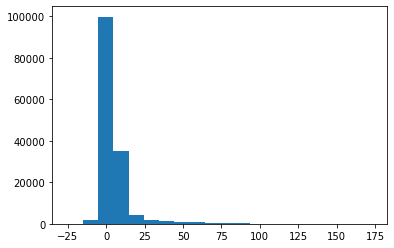

In [13]:
import matplotlib.pyplot as plt

diff = ((D1 - D2)).flatten()

plt.hist(diff, 20)

In [75]:
np.save('intensities/usa_99_ds23.npy', I1)
np.save('intensities/usa_99_ds23_csak.npy', I2)

# SRLG collection

In [ ]:
min_cut_srlgs = get_minimal_cut_SRLGs('PSRLGs/usa_99_complete_it6.xml')
len(min_cut_srlgs)

In [15]:
srlgs, srlg_probs = get_SRLGs('PSRLGs/usa_99_complete_it6.xml')

In [346]:
sum(srlg_probs)

0.13014360751392431

In [9]:
# The network
g = nx.read_gml('networks/usa_99.gml', label="id")
L = len(g.edges)
links = range(L)

# The matrix of the intensity values, dimensions: [L,P,M] (link, position, magnitude)
I1 = np.load('intensities/usa_99_ds23.npy')
I2 = np.load('intensities/usa_99_ds23_csak.npy')

# The matrix of earthquake probabilities, dimensions: [P,M] (position, magnitude)
prob_matrix = pd.read_csv('earthquake_probabilities/usa_ds23.csv').drop(['Lat', 'Long'], axis=1).to_numpy()
P, M = prob_matrix.shape
epicenters = range(P)
magnitudes = range(M)

srlgs, srlg_probs = get_SRLGs('PSRLGs/usa_99_complete_it6.xml')
H = np.ones(L) * 6.

In [ ]:
H = np.ones(L) * 6.
for T in np.concatenate((np.arange(0.01, 0.001, -0.001), np.arange(0.001, 0.0007, -0.0001))):
#for T in np.arange(0.01, 0.007, -0.001):
    print(f'=====================\n{T:.4f}')
    for i in range(len(srlgs)):
        if srlg_probs[i] > T:
            print(f'{srlg_probs[i]:.4f}, {get_SRLG_probability(srlgs[i],g,I1,H,prob_matrix):.4f}, {get_SRLG_probability(srlgs[i],g,I2,H,prob_matrix):.4f},{srlgs[i]}')

In [365]:
# Correcting node order in SRLG edges
edge_list = list(g.edges)
for idx,srlg in enumerate(srlgs):
    for l in srlg:
        if l not in edge_list:
            srlgs[idx].discard(l)
            srlgs[idx].add((l[1],l[0],l[2]))

In [22]:
# Write
with open('min_cut_SRLGs/usa_99', 'wb') as fp:
    pickle.dump(min_cut_srlgs, fp)

# Read
#with open ('min_cut_SRLGs/italy', 'rb') as fp:
#    cut_srlgs = pickle.load(fp)

# Creating SRG file

In [9]:
g = read_lgf_to_networkx_extended('networks/usa_99.lgf')

with open ('results/Heuristic_upgraded_edges_usa_99_nospine', 'rb') as fp:
    cut_srlgs = pickle.load(fp)

In [36]:
write_networkx_to_srg('networks/usa_99.srg', g, srlgs)

0